In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/mehdi/github/LSSutils')
import numpy as np
import fitsio as ft
from lssutils.lab import MeanDensity
from lssutils.utils import nmag2mag, ivar2depth

In [4]:
from scipy.stats import binned_statistic
from lssutils.utils import hpixsum
import pandas as pd

def hist(ngal, frac, syst, bins):
    """ A function to bin galaxy counts and 
    """
    ng,_,_ = binned_statistic(syst, ngal, statistic='sum', bins=bins)
    nr,_,_ = binned_statistic(syst, frac, statistic='sum', bins=bins)
    ns,_,_ = binned_statistic(syst, syst, statistic='mean', bins=bins)

    norm = ng.sum()/nr.sum()
    mean = ng/(nr*norm)

    return (ns, mean)

In [2]:
region = 'NDECALS'

dcat = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_BGS_ANY_{region}.fits')
rcat = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/{region}_randoms-1-0x2.fits')
wsys = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_BGS_ANY_{region}.fits_EdWsys/wsys_v0.fits')['wsys']

In [5]:
df = pd.read_hdf('/home/mehdi/data/templates/dr9/pixweight_dark_dr9m_nside256.h5')
ebv = df['ebv'].values

In [6]:
wsys.size, dcat.size

(8545662, 8545662)

In [7]:
rcuts = {'A':19.5, 'B':18.5, 'C':17.5}
flux_r = nmag2mag(dcat['FLUX_R']/dcat['MW_TRANSMISSION_R'])


n_bgs_ = {}
n_bgs = {}
for name, r_cut in rcuts.items():
    ms = flux_r < r_cut
    n_bgs[name] = hpixsum(256, dcat['RA'][ms], dcat['DEC'][ms], weights=wsys[ms])
    n_bgs_[name] = hpixsum(256, dcat['RA'][ms], dcat['DEC'][ms])*1.0
    print(name, r_cut, ms.sum())
    
r_bgs = hpixsum(256, rcat['RA'], rcat['DEC'])*1.0

A 19.5 4950456
B 18.5 1663235
C 17.5 527154


(array([  425.,   615.,    89.,   138.,   291.,   142.,  7271., 72846.,
        30858.,   550.]),
 array([0.00385593, 0.13418628, 0.26451663, 0.39484698, 0.52517732,
        0.65550767, 0.78583802, 0.91616837, 1.04649872, 1.17682907,
        1.30715942]),
 <a list of 10 Patch objects>)

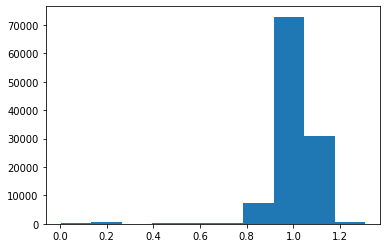

In [8]:
frac = r_bgs / r_bgs[r_bgs>0].mean()
mask = frac > 0.5
plt.hist(frac[frac>0])

In [9]:
bins = np.logspace(*np.log10(np.percentile(ebv[mask], [1, 99])), 9)


nbar = {}
nbar_ = {}
for name in n_bgs_:
    nbar_[name] = hist(n_bgs_[name][mask], frac[mask], ebv[mask], bins)
    nbar[name] = hist(n_bgs[name][mask], frac[mask], ebv[mask], bins)    
    print(name)

A
B
C


A No Wsys
A W/ Wsys
B No Wsys
B W/ Wsys
C No Wsys
C W/ Wsys


Text(0, 0.5, 'Mean Density')

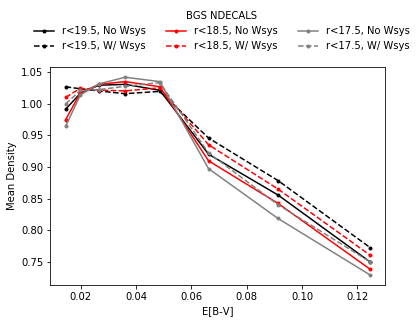

In [11]:
colors = {'A':'k', 'B':'r', 'C':'grey'}
ls = ['-', '--']

for sample in 'ABC':
    i = 0
    for method, nbar_i in zip(['No Wsys', 'W/ Wsys'], [nbar_, nbar]):
         
        plt.plot(*nbar_i[sample], marker='.', label=f'r<%.1f, %s'%(rcuts[sample], method),
                color=colors[sample], ls=ls[i])
        print(sample, method)
        i += 1
        
plt.legend(ncol=3, bbox_to_anchor=(1.1, 1.3), frameon=False, title=f'BGS {region}')
# plt.xscale('log')
plt.xlabel('E[B-V]')
plt.ylabel('Mean Density')